## EPL fixture by fixture and Final League Table predition
###### by: Jeremiah Chinyelugo

Football has always been my favourite sport, my first memory of football goes as far back as the 2008 champions league final between Manchester United and Chelsea. I remember watching that game with my brother (a Machester United fan) who was so excited when United won the game on penalties. I enjoyed that game as well, and that is how my love-hate realtionship with Manchester United began.

The English Premier League is the most watched domestic league in the world with audiences of around 4.7 billion poeple. 20 teams play each other twice, once at home and once away, playing a total of 38 games a season, with the team with the most points winning the league.

There are several factors that go into deciding the outcome of a game in football. The unpredictability of each game, especially in the EPL, makes the game special, that is why i decided to combine my love for football and data science by playing with some data and hopefully build a model that can predict the outcome of a premier league fixture given a set of features.

Like i stated earlier, the winner of the EPL is determined primarily by the points accumulated through out the course of the season, with goal difference breaking any deadlock. The outcome of a match can either be a Win, Draw or Loss, but for the sake of simplicity we will try to determine the probability of a team winning a fixture. Even though the premier league is unpredictable, there are still some strong indications that can help determine which team will win a fixture. For example, teams that have won a lot of their games at home, won the premier league in the last 5 years or score a lot of goals are more likely to win a fixture.

The data we will be using for this project will be scrapped from a football website and will be cleaned to make the data usable for our intended purpose. Unfortunately, some in-game statistics like: XG, XA, corners taken, shots on target, fouls, chances created will have to be left out. While they are great features, they however are in-game stats, meaning they can only be obtained when the game is ongoing, so won't have them available when trying to predict the outcome of an upcoming fixture.

### Importing the Packages

In [1]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Scrapping the data from ''fbref.com''
*Uncomment to scrap new data*

In [2]:
# url = "https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures"

# content = requests.get(url).text

In [3]:
# soup = BeautifulSoup(content, 'lxml')

In [4]:
# dates = [soup.find_all('td', class_='left', attrs={'data-stat':"date"})[i].text for i in range(426)]
# H_T = [soup.find_all('td', class_='right', attrs={'data-stat':"squad_a"})[i].text for i in range(426)]
# A_T = [soup.find_all('td', class_='left', attrs={'data-stat':"squad_b"})[i].text for i in range(426)]
# scores = [soup.find_all('td', class_='center', attrs={'data-stat':"score"})[i].text for i in range(426)]
# xg_a = [soup.find_all('td', class_='right', attrs={'data-stat':"xg_a"})[i].text for i in range(426)]
# xg_b = [soup.find_all('td', class_='right', attrs={'data-stat':"xg_b"})[i].text for i in range(426)]

In [5]:
# saving the file as a csv

# pd.DataFrame({'Date':dates, 'HomeTeam':H_T, 'AwayTeam':A_T, 'score':scores,
#                    'xg_HT':xg_a, 'xg_AT':xg_b}).to_csv('epl2022.csv')

### Data Cleaning

In [6]:
# storing the data in a dataframe

path = "/kaggle/input/epl2022/epl2022.csv"
df = pd.read_csv(path).drop('Unnamed: 0', axis=1).fillna('')

when scrapping the data from `fbref.com`, some blank values were included to separate each game week, because they are useless in what we are trying to achieve, i will be selecting only rows where we have at least 1 data available.

In [7]:
df = df[df['HomeTeam'] != ''].reset_index(drop=True)
df

,Date,HomeTeam,AwayTeam,score,xg_HT,xg_AT
0,2021-08-13,Brentford,Arsenal,2–0,1.3,1.4
1,2021-08-14,Manchester Utd,Leeds United,5–1,1.5,0.6
2,2021-08-14,Leicester City,Wolves,1–0,0.8,1.1
3,2021-08-14,Burnley,Brighton,1–2,1.0,1.3
4,2021-08-14,Watford,Aston Villa,3–2,1.2,1.1
...,...,...,...,...,...,...
374,2022-05-22,Manchester City,Aston Villa,,,
375,2022-05-22,Burnley,Newcastle Utd,,,
376,2022-05-22,Arsenal,Everton,,,
377,2022-05-22,Crystal Palace,Manchester Utd,,,


We can see from our dataframe that the scores for each match are combined. Therefore, we will need to separate them into home and away goals to have a better idea of how each team performed. <br></br> <br></br>
`NB:` Because we scrapped all fixtures and their results from fbref, we have some fixtures without results because the season is ongoing. To make sure we don't tamper with our data. We will append `""` wherever we have a fixture without a score.

In [8]:
HT_G, AT_G = [], []
for i, data in df.iterrows():
    if data['score'] != '':
        HT_G.append(data['score'][0])
        AT_G.append(data['score'][2])
    else:
        HT_G.append('')
        AT_G.append('')

We then select just the important features to use going forward

In [9]:
df['HT_G'] = HT_G
df['AT_G'] = AT_G

df = df[['HomeTeam', 'HT_G', 'AT_G', 'AwayTeam']]

In [10]:
df.head(10)

,HomeTeam,HT_G,AT_G,AwayTeam
0,Brentford,2,0,Arsenal
1,Manchester Utd,5,1,Leeds United
2,Leicester City,1,0,Wolves
3,Burnley,1,2,Brighton
4,Watford,3,2,Aston Villa
5,Chelsea,3,0,Crystal Palace
6,Everton,3,1,Southampton
7,Norwich City,0,3,Liverpool
8,Newcastle Utd,2,4,West Ham
9,Tottenham,1,0,Manchester City


Before going ahead, we need to create a Premier League Table.<br></br>
To do this, we will define a class that will handle:
* adding the teams
* creating the table
* updating the table by adding fixture results
* sorting the table

## Premier League Table

In [11]:
class LeagueTable:
    def __init__(self, teams):
        self.teams = teams
        self.table = pd.DataFrame({'Team':teams, 'P': [0]*20, 'W': [0]*20, 'D':[0]*20, 'L':[0]*20,
                                  'F':[0]*20, 'A':[0]*20, 'GD':[0]*20, 'Pts':[0]*20})
        
        
    def sort_table(self):
        self.table.sort_values('Team', inplace=True)
        self.table.sort_values(['Pts','GD','F'], ascending=False, inplace=True)
        self.table.index = np.arange(1,21)
    
    def show_table(self):
        self.sort_table()
        return self.table
    
    def add_result(self, teamA, teamAScore, teamB, teamBScore):
        self.table.loc[self.table['Team'] == teamA, 'P'] += 1
        self.table.loc[self.table['Team'] == teamB, 'P'] += 1
        self.table.loc[self.table['Team'] == teamA, 'Pts'] += 3 if teamAScore > teamBScore else 1 if teamAScore == teamBScore else 0
        self.table.loc[self.table['Team'] == teamB, 'Pts'] += 3 if teamBScore > teamAScore else 1 if teamAScore == teamBScore else 0
        self.table.loc[self.table['Team'] == teamA, 'W'] += 1 if teamAScore > teamBScore else 0
        self.table.loc[self.table['Team'] == teamB, 'W'] += 1 if teamBScore > teamAScore else 0
        self.table.loc[self.table['Team'] == teamA, 'D'] += 1 if teamAScore == teamBScore else 0
        self.table.loc[self.table['Team'] == teamB, 'D'] += 1 if teamBScore == teamAScore else 0
        self.table.loc[self.table['Team'] == teamA, 'L'] += 1 if teamBScore > teamAScore else 0
        self.table.loc[self.table['Team'] == teamB, 'L'] += 1 if teamAScore > teamBScore else 0
        self.table.loc[self.table['Team'] == teamA, 'GD'] += int(teamAScore - teamBScore)
        self.table.loc[self.table['Team'] == teamB, 'GD'] += int(teamBScore - teamAScore)
        self.table.loc[self.table['Team'] == teamA, 'F'] += teamAScore
        self.table.loc[self.table['Team'] == teamB, 'F'] += teamBScore
        self.table.loc[self.table['Team'] == teamA, 'A'] += teamBScore
        self.table.loc[self.table['Team'] == teamB, 'A'] += teamAScore
        self.sort_table()
        return self.table
        
        

In [12]:
df['HomeTeam'].unique()

array(['Brentford', 'Manchester Utd', 'Leicester City', 'Burnley',
       'Watford', 'Chelsea', 'Everton', 'Norwich City', 'Newcastle Utd',
       'Tottenham', 'Liverpool', 'Aston Villa', 'Manchester City',
       'Crystal Palace', 'Leeds United', 'Brighton', 'Southampton',
       'Wolves', 'Arsenal', 'West Ham'], dtype=object)

In [13]:
t = LeagueTable(df['HomeTeam'].unique())
t.show_table()

,Team,P,W,D,L,F,A,GD,Pts
1,Arsenal,0,0,0,0,0,0,0,0
2,Aston Villa,0,0,0,0,0,0,0,0
3,Brentford,0,0,0,0,0,0,0,0
4,Brighton,0,0,0,0,0,0,0,0
5,Burnley,0,0,0,0,0,0,0,0
6,Chelsea,0,0,0,0,0,0,0,0
7,Crystal Palace,0,0,0,0,0,0,0,0
8,Everton,0,0,0,0,0,0,0,0
9,Leeds United,0,0,0,0,0,0,0,0
10,Leicester City,0,0,0,0,0,0,0,0


## Feature Engineering

Like i mentioned above, the season is ongoing so some fixtures have been played while some haven't.<br></br>
The purpose of this project is to make an attempt at predicting the outcomes of each game. To do this, we need to separate our data into the train set (played fixtures) and the test set (unplayed fixtures) which we will make our predictions on.

In [14]:
happened_games = df[df['HT_G'] != ''].copy().reset_index(drop=True)
games_left = df[df['HT_G'] == ''].copy().reset_index(drop=True)

#### Features

Because of how limited our data is in terms of features, we have to create some which will be trained on a machine learning algorithm to make predictions.

In [15]:
happened_games['HomeTeam_position'] = [0] * len(happened_games)
happened_games['AwayTeam_position'] = [0] * len(happened_games)
happened_games['HomeTeam_Point'] = [0] * len(happened_games)
happened_games['AwayTeam_Point'] = [0] * len(happened_games)
happened_games['HomeTeam_form1'] = [0] * len(happened_games)
happened_games['HomeTeam_form2'] = [0] * len(happened_games)
happened_games['HomeTeam_form3'] = [0] * len(happened_games)
happened_games['AwayTeam_form1'] = [0] * len(happened_games)
happened_games['AwayTeam_form2'] = [0] * len(happened_games)
happened_games['AwayTeam_form3'] = [0] * len(happened_games)
happened_games['HomeTeam_WinRate'] = [0] * len(happened_games)
happened_games['HomeTeam_LossRate'] = [0] * len(happened_games)
happened_games['AwayTeam_WinRate'] = [0] * len(happened_games)
happened_games['AwayTeam_LossRate'] = [0] * len(happened_games)
happened_games.head()

,HomeTeam,HT_G,AT_G,AwayTeam,HomeTeam_position,AwayTeam_position,HomeTeam_Point,AwayTeam_Point,HomeTeam_form1,HomeTeam_form2,HomeTeam_form3,AwayTeam_form1,AwayTeam_form2,AwayTeam_form3,HomeTeam_WinRate,HomeTeam_LossRate,AwayTeam_WinRate,AwayTeam_LossRate
0,Brentford,2,0,Arsenal,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Manchester Utd,5,1,Leeds United,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Leicester City,1,0,Wolves,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Burnley,1,2,Brighton,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Watford,3,2,Aston Villa,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Home & Away Team position

The 1st and 2nd feature we will be adding is the Home & Away Team's position in the premier league table after each game.

How will this work? 

1. We will loop through all the games that have been played so far
2. The position of all teams in the premier league at the beginning of the season i.e (no games played) will be gotten from the premier league table we created above using the `LeagueTable` class.
3. The results of each game, and the teams involved will then be added to the table using the `.add_result` method. Adding the results will update the table, with each team having updated stats. The newly updated position of each Home & Away team will then be added to the `HomeTeam_Position` & `AwayTeam_Position` columns after each game week.

In [16]:
for i, data in happened_games.iterrows():
    happened_games.iloc[i, 4] = t.show_table().loc[t.show_table()['Team'] == data['HomeTeam']].index[0]
    happened_games.iloc[i, 5] = t.show_table().loc[t.show_table()['Team'] == data['AwayTeam']].index[0]
    t.add_result(data['HomeTeam'], int(data['HT_G']), data['AwayTeam'], int(data['AT_G']))

### Home & Away Team points

The 3rd and 4th feature will we adding is the Home & Away Team's points

How will this work?

1. Create two dictionaries for the both home and away team, with the teams as the keys.
2. For each fixture that has been played, we will append `3` to the list of values of the home or away team, IF they won the game, or `1` if the game ended in a draw, else `0` will be appended to the list.
3. For each team in the home & away team dictionary, the cummulative sum of points accumulated will be calculated.
4. Going through all the keys i.e (teams) in both dictionaries, we will get the dataframe index when that team is the home team and when it is the away team, then assigned the cummulative sum to their respective columns. 

`NB`: The caveat here is, we applying the cummulative points from the previous game to the current fixture. i.e (for gameweek 1 we will have no cummulative points for the Home & Away team beacause the season just started, for gameweek 2, we will use the points from gameweek 1, 3 if the team won, 1 if it ended in a draw)

In [17]:
H_teams, A_teams = {}, {}
for i in t.show_table()['Team'].unique():
    H_teams[i] = []
    A_teams[i] = []

for i, data in happened_games.iterrows():
    HT = data['HomeTeam']
    AT = data['AwayTeam']
    H_teams[HT].append(3 if data['HT_G'] > data['AT_G'] else 1 if data['HT_G'] == data['AT_G'] else 0)
    A_teams[AT].append(3 if data['AT_G'] > data['HT_G'] else 1 if data['HT_G'] == data['AT_G'] else 0)
    
for k, v in H_teams.items():
        v = np.cumsum(v)
        H_teams[k] = v
        
for k, v in A_teams.items():
        v = np.cumsum(v)
        A_teams[k] = v
        

for team in happened_games['HomeTeam'].unique():
    HT_idx = happened_games[happened_games['HomeTeam'] == team].index[1:]
    AT_idx = happened_games[happened_games['AwayTeam'] == team].index[1:]

    happened_games.iloc[HT_idx, 6] = H_teams[team][:-1]
    happened_games.iloc[AT_idx, 7] = A_teams[team][:-1]

### Home & Away Team form

The 5th, 6th, 7th, 8th, 9th and 10th feature we will be adding is the Home & Away Team form. For each team, we will get the form from the last 3 games. i.e (Home Team will have the last 3 HOME form and vice versa for the Away team). 

The form will be represented with either a `1` meaning they won or a `0` meaning they didn't win (draw or loss).

The home and away team will have 3 forms: form1, form2, form3, with form1 being the most recent, followed by form2 then form3 being the result from 3 games ago.

How will this work?

1. We will create new columns, H_Result and A_Result to know which team won the fixture.
2. For each team out of the 20 teams, we will get their index from the dataframe when they are the home and away team.
3. Then apply the form to their respective columns using the index.

In [18]:
happened_games['H_Result'] = np.where(happened_games['HT_G'] > happened_games['AT_G'], 1, 0)
happened_games['A_Result'] = np.where(happened_games['AT_G'] > happened_games['HT_G'], 1, 0)

In [19]:
for team in happened_games['HomeTeam'].unique():
    HT_idx = happened_games[happened_games['HomeTeam'] == team].index
    AT_idx = happened_games[happened_games['AwayTeam'] == team].index
    
    H_form_list = list(happened_games[happened_games['HomeTeam'] == team]['H_Result'])
    A_form_list = list(happened_games[happened_games['AwayTeam'] == team]['A_Result'])
    
    happened_games.iloc[HT_idx, 8] = [0] + H_form_list[:-1]
    happened_games.iloc[HT_idx, 9] = [0]*2 + H_form_list[:-2]
    happened_games.iloc[HT_idx, 10] = [0]*3 + H_form_list[:-3]
    
    happened_games.iloc[AT_idx, 11] = [0] + A_form_list[:-1]
    happened_games.iloc[AT_idx, 12] = [0]*2 + A_form_list[:-2]
    happened_games.iloc[AT_idx, 13] = [0]*3 + A_form_list[:-3]

### Home & Away Team Win rate

The 12th, 13th, 14th & 15th feature we will be adding is the Home & Away Win and Loss Rate.

How will this work? 

1. Create two dictionaries for the both home and away team, with the teams as the keys.
2. For each fixture that has been played, we will append `1` to the list of values of the home or away team, IF they won the game, or `0` if they didn't. (opposite for loss rate)
3. For each team in the home & away team dictionary, the cummulative sum of wins/loss accumulated will be calculated.
4. For each team in the home & away team dictionary, the rate, i.e (cummulative sum of points / number of games played so far) will be calculated.
5. Going through all the keys i.e (teams) in both dictionaries, we will get the dataframe index when that team is the home team and when it is the away team, then assigned the rate to their respective columns. 

In [20]:
H_teams, A_teams = {}, {}
for i in t.show_table()['Team'].unique():
    H_teams[i] = []
    A_teams[i] = []

for i, data in happened_games.iterrows():
    HT = data['HomeTeam']
    AT = data['AwayTeam']
    H_teams[HT].append(1 if data['HT_G'] > data['AT_G'] else 0)
    A_teams[AT].append(1 if data['AT_G'] > data['HT_G'] else 0)
    
for k, v in H_teams.items():
        v = np.cumsum(v)
        H_teams[k] = v
        
for k, v in A_teams.items():
        v = np.cumsum(v)
        A_teams[k] = v
        

        
for k, v in H_teams.items():
    val = []
    for i in range(1, len(v)+1):
        val.append(v[i-1] / i)
    H_teams[k] = val
    
for k, v in A_teams.items():
    val = []
    for i in range(1, len(v)+1):
        val.append(v[i-1] / i)
    A_teams[k] = val
        

for team in happened_games['HomeTeam'].unique():
    HT_idx = happened_games[happened_games['HomeTeam'] == team].index
    AT_idx = happened_games[happened_games['AwayTeam'] == team].index

    happened_games.iloc[HT_idx, 14] = [0] + H_teams[team][:-1]
    happened_games.iloc[AT_idx, 16] = [0] + A_teams[team][:-1]

### Home & Away Team Loss rate

In [21]:
H_teams, A_teams = {}, {}
for i in t.show_table()['Team'].unique():
    H_teams[i] = []
    A_teams[i] = []

for i, data in happened_games.iterrows():
    HT = data['HomeTeam']
    AT = data['AwayTeam']
    H_teams[HT].append(1 if data['AT_G'] > data['HT_G'] else 0)
    A_teams[AT].append(1 if data['HT_G'] > data['AT_G'] else 0)
    
for k, v in H_teams.items():
        v = np.cumsum(v)
        H_teams[k] = v
        
for k, v in A_teams.items():
        v = np.cumsum(v)
        A_teams[k] = v
        

        
for k, v in H_teams.items():
    val = []
    for i in range(1, len(v)+1):
        val.append(v[i-1] / i)
    H_teams[k] = val
    
for k, v in A_teams.items():
    val = []
    for i in range(1, len(v)+1):
        val.append(v[i-1] / i)
    A_teams[k] = val
        

for team in happened_games['HomeTeam'].unique():
    HT_idx = happened_games[happened_games['HomeTeam'] == team].index
    AT_idx = happened_games[happened_games['AwayTeam'] == team].index

    happened_games.iloc[HT_idx[1:], 15] = H_teams[team][:-1]
    happened_games.iloc[AT_idx[1:], 17] = A_teams[team][:-1]

The 16th, 17th, 18th, 19th, 20th and 21st feature we will be adding will determine if the:
* Home & Away team was a previous epl winner in the past 5 years
* Home & Away team made the top 4 at least 3 times in the past 5 years
* Home & Away team was playing in the championship in the past 5 years

In [22]:
def is_previous_winner(team):
    winners = ['Chelsea', 'Manchester City', 'Liverpool']
    return 1 if team in winners else 0

def is_previous_top_4(team):
    top_4 = ['Manchester City', 'Liverpool', 'Chelsea', 'Tottenham', 'Manchester Utd']
    return 1 if team in top_4 else 0

def is_championship(team):
    championship = ['Brentford', 'Watford', 'Norwich City', 'Burnley', 'Newcastle Utd', 'Aston Villa', 'Leeds United',
                   'Wolves', 'Brighton']
    return 1 if team in championship else 0

def in_europe(team):
    europe = ['Chelsea', 'Manchester City', 'Liverpool', 'Arsenal', 'Manchester Utd', 'Leicester City', 'Tottenham', 'West Ham']
    return 1 if team in europe else 0

happened_games['teamAPrevWinner'] = happened_games['HomeTeam'].apply(is_previous_winner)
happened_games['teamBPrevWinner'] = happened_games['AwayTeam'].apply(is_previous_winner)
happened_games['teamAPrevTop4'] = happened_games['HomeTeam'].apply(is_previous_top_4)
happened_games['teamBPrevTop4'] = happened_games['AwayTeam'].apply(is_previous_top_4)
happened_games['teamAPrevChampionship'] = happened_games['HomeTeam'].apply(is_championship)
happened_games['teamBPrevChampionship'] = happened_games['AwayTeam'].apply(is_championship)
happened_games['teamAPrevEurope'] = happened_games['AwayTeam'].apply(in_europe)
happened_games['teamBPrevEurope'] = happened_games['AwayTeam'].apply(in_europe)

##### Correlation

It is important know how each of our features are correlated with each other. To understand this, we plot a heatmap of the correlation matrix.

In [23]:
corr = happened_games[['H_Result', 'A_Result', 'AT_G','HomeTeam', 'AwayTeam', 'HomeTeam_position',
       'AwayTeam_position', 'HomeTeam_Point', 'AwayTeam_Point',
       'HomeTeam_form1', 'HomeTeam_form2', 'HomeTeam_form3', 'AwayTeam_form1',
       'AwayTeam_form2', 'AwayTeam_form3', 'HomeTeam_WinRate',
       'HomeTeam_LossRate', 'AwayTeam_WinRate', 'AwayTeam_LossRate',
       'teamAPrevWinner', 'teamBPrevWinner',
       'teamAPrevTop4', 'teamBPrevTop4', 'teamAPrevChampionship',
       'teamBPrevChampionship']].corr()

np.fill_diagonal(corr.to_numpy(), 0)

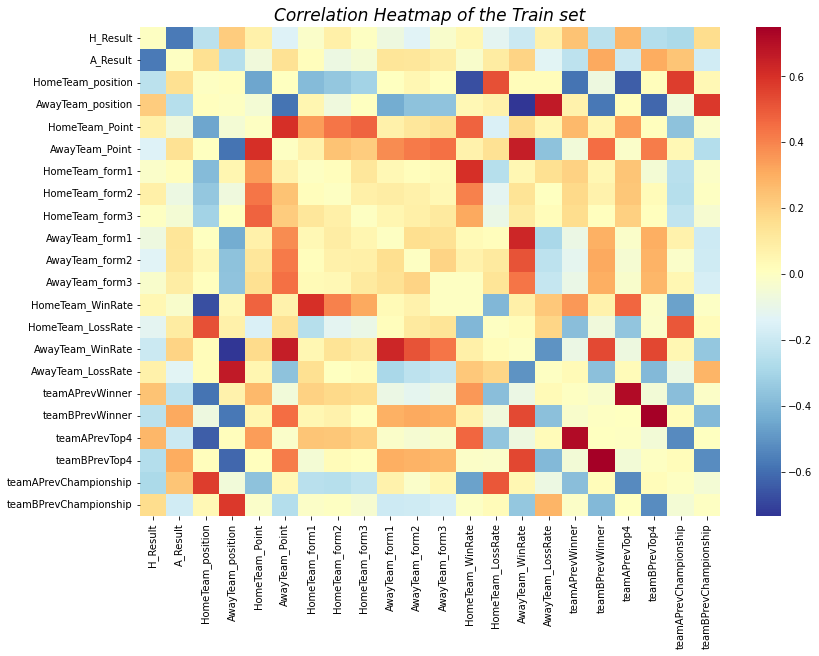

In [24]:
plt.figure(figsize=(13,9))
sns.heatmap(corr, cmap='RdYlBu_r')
plt.title('Correlation Heatmap of the Train set', size=17, style='italic')
plt.show()

From the heatmap of the correlation matrix, we can see that the outcome for the Home Team (H_Result) depends on features like:
* Away Team position - the higher the position number (i.e 20th) the easier it is to get a positive result
* Home Team point - the home team is more likely to win if they have high points at home
* teamAPrevWinner - if the team has previously won the EPL, they are more likely to win
* teamAtop4 - if the team has been in the top 4 three times in the last 5 years, they are more likely to win
* teamBPrevChampionship - if the opposing team was in the championship, the home team is likely to win

Next we need to spit our training data set into X (train) and y (target)

In [25]:
X = happened_games.drop(['A_Result', 'H_Result', 'HomeTeam', 'AwayTeam', 'HT_G', 'AT_G'], axis=1).copy()
y = happened_games['H_Result']

We also need to scale our data using the standard scaler to centralized our data and make all our features be within the same range.

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

#### Importing the algorithms

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(weights='distance')
log_clf = LogisticRegression(max_iter = 1_000, random_state=19, C=0.01, fit_intercept=True)
rnd_clf = RandomForestClassifier(random_state=19, max_depth=7, min_samples_leaf=1, min_samples_split=4, n_estimators=50)
svc_clf = SVC(probability=True, random_state=19)
grd_clf = GradientBoostingClassifier(random_state=19)

Importing the metrics for evaluating our data

In [28]:
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import f1_score, accuracy_score

In [29]:
models = [knn_clf, log_clf, rnd_clf, svc_clf, grd_clf]

for model in models:
    model.fit(X_transformed, y)
    score = cross_val_score(model, X_transformed, y, cv=10)
    
    print(model.__class__.__name__,"cross val score accuracy: ",score.mean(),'\n')

KNeighborsClassifier cross val score accuracy:  0.6583333333333333 

LogisticRegression cross val score accuracy:  0.6969202898550723 

RandomForestClassifier cross val score accuracy:  0.6759057971014493 

SVC cross val score accuracy:  0.6755434782608696 

GradientBoostingClassifier cross val score accuracy:  0.6539855072463767 



In [30]:
X1, y1 = X_transformed[:200], y[:200]
X2, y2 = X_transformed[200:], y[200:]

log_clf.fit(X1, y1)
pred = log_clf.predict(X2)

print(f"Model Accuracy: {accuracy_score(y2, pred):.2%}")

Model Accuracy: 70.59%


After training several models, we obtained a model with a `70%` cross validation accuracy. From these result, we can tell the model is underfitted, meaning the data provided only captures `~70%` of the reasons for the outcome. This isn't entirely bad considering we had to create 21 new features from the result of a game, also, because of the various amounts of factors that affect a football game; weather, player fitness, referee decision, in-game tactics, red / yellow cards, transfers, injuries, player errors, it isn't possible to entirely capture all variables that affect the outcome of a game.

So, in my opinion, given the limited data and features, this is a decent model.

*You could add more features to this model to get an improved model*

### This is the premier league table as at 18th - February - 2022

In [31]:
t.show_table()

,Team,P,W,D,L,F,A,GD,Pts
1,Manchester City,25,20,3,2,61,14,47,63
2,Liverpool,24,16,6,2,61,19,42,54
3,Chelsea,24,13,8,3,48,18,30,47
4,Manchester Utd,25,12,7,6,40,32,8,43
5,West Ham,25,12,5,8,44,33,11,41
6,Arsenal,22,12,3,7,34,25,9,39
7,Wolves,23,11,4,8,21,17,4,37
8,Tottenham,22,11,3,8,28,29,-1,36
9,Brighton,24,7,12,5,25,25,0,33
10,Southampton,24,6,11,7,30,37,-7,29


## Testing the Model

Now we can use the trained model to predict the probabilty of each team winning a fixture.

Before we begin, we need to drop the `H_Result` & `A_Result` columns from the happened_games dataframe beacuse we want to add test set dataframe to it after every prediction is made.

In [32]:
happened_games.drop(['H_Result', 'A_Result'], inplace=True, axis=1)

In [33]:
games_left['HomeTeam_position'] = [0] * len(games_left)
games_left['AwayTeam_position'] = [0] * len(games_left)
games_left['HomeTeam_Point'] = [0] * len(games_left)
games_left['AwayTeam_Point'] = [0] * len(games_left)
games_left['HomeTeam_form1'] = [0] * len(games_left)
games_left['HomeTeam_form2'] = [0] * len(games_left)
games_left['HomeTeam_form3'] = [0] * len(games_left)
games_left['AwayTeam_form1'] = [0] * len(games_left)
games_left['AwayTeam_form2'] = [0] * len(games_left)
games_left['AwayTeam_form3'] = [0] * len(games_left)
games_left['HomeTeam_WinRate'] = [0] * len(games_left)
games_left['HomeTeam_LossRate'] = [0] * len(games_left)
games_left['AwayTeam_WinRate'] = [0] * len(games_left)
games_left['AwayTeam_LossRate'] = [0] * len(games_left)
games_left.head()

,HomeTeam,HT_G,AT_G,AwayTeam,HomeTeam_position,AwayTeam_position,HomeTeam_Point,AwayTeam_Point,HomeTeam_form1,HomeTeam_form2,HomeTeam_form3,AwayTeam_form1,AwayTeam_form2,AwayTeam_form3,HomeTeam_WinRate,HomeTeam_LossRate,AwayTeam_WinRate,AwayTeam_LossRate
0,Brighton,,,Tottenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Aston Villa,,,Burnley,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wolves,,,Watford,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Burnley,,,Everton,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Leeds United,,,Aston Villa,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
games_left['teamAPrevWinner'] = games_left['HomeTeam'].apply(is_previous_winner)
games_left['teamBPrevWinner'] = games_left['AwayTeam'].apply(is_previous_winner)
games_left['teamAPrevTop4'] = games_left['HomeTeam'].apply(is_previous_top_4)
games_left['teamBPrevTop4'] = games_left['AwayTeam'].apply(is_previous_top_4)
games_left['teamAPrevChampionship'] = games_left['HomeTeam'].apply(is_championship)
games_left['teamBPrevChampionship'] = games_left['AwayTeam'].apply(is_championship)
games_left['teamAPrevEurope'] = games_left['AwayTeam'].apply(in_europe)
games_left['teamBPrevEurope'] = games_left['AwayTeam'].apply(in_europe)

### Adding the remaining features and making predictions

Because we are trying to get the probability that a team will win or not. It might seem unfair to give the win to a team if the difference in probability for both teams is less than 5%. So what we will do is, if the probability of a team winning a game is greater than or equal to 47.5%, with the opposing team having a probability of less than or equal to 52.5% then both teams will draw the game. This can also be interpreted that team A (with 47.5% probability) can lose OR draw the game while team B (with 52.5% probability) can win OR draw the game.

In [35]:
for i, data in games_left.iterrows():
    games_left.iloc[i, 4] = t.show_table().loc[t.show_table()['Team'] == data['HomeTeam']].index[0]
    games_left.iloc[i, 5] = t.show_table().loc[t.show_table()['Team'] == data['AwayTeam']].index[0]
    
    games_left.iloc[i, 6] = happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HomeTeam_Point'] + (3 if happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HT_G'] > happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['AT_G'] else 1 if happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HT_G'] == happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['AT_G'] else 0)
    games_left.iloc[i, 7] = happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AwayTeam_Point'] + (3 if happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AT_G'] > happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['HT_G'] else 1 if happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AT_G'] == happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['HT_G'] else 0)
    
    games_left.iloc[i, 8] = 1 if happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HT_G'] > happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['AT_G'] else 0
    games_left.iloc[i, 9] = happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HomeTeam_form1']
    games_left.iloc[i, 10] = happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HomeTeam_form2']
    
    games_left.iloc[i, 11] = 1 if happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AT_G'] > happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['HT_G'] else 0
    games_left.iloc[i, 12] = happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AwayTeam_form1']
    games_left.iloc[i, 13] = happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AwayTeam_form2']
    
    games_left.iloc[i, 14] = (happened_games[happened_games['HomeTeam'] == data['HomeTeam']]['HomeTeam_WinRate'].iloc[-1] * (len(happened_games[happened_games['HomeTeam'] == data['HomeTeam']]) - 1) + (1 if happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HT_G'] > happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['AT_G'] else 0)) / (len(happened_games[happened_games['HomeTeam'] == data['HomeTeam']]) + 1)
    games_left.iloc[i, 16] = (happened_games[happened_games['AwayTeam'] == data['AwayTeam']]['AwayTeam_WinRate'].iloc[-1] * (len(happened_games[happened_games['AwayTeam'] == data['AwayTeam']]) - 1) + (1 if happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AT_G'] > happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['HT_G'] else 0)) / (len(happened_games[happened_games['AwayTeam'] == data['AwayTeam']]) + 1)
    
    games_left.iloc[i, 15] = (happened_games[happened_games['HomeTeam'] == data['HomeTeam']]['HomeTeam_LossRate'].iloc[-1] * (len(happened_games[happened_games['HomeTeam'] == data['HomeTeam']]) - 1) + (1 if happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['AT_G'] > happened_games[happened_games['HomeTeam'] == data['HomeTeam']].iloc[-1]['HT_G'] else 0)) / (len(happened_games[happened_games['HomeTeam'] == data['HomeTeam']]) + 1)
    games_left.iloc[i, 17] = (happened_games[happened_games['AwayTeam'] == data['AwayTeam']]['AwayTeam_LossRate'].iloc[-1] * (len(happened_games[happened_games['AwayTeam'] == data['AwayTeam']]) - 1) + (1 if happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['HT_G'] > happened_games[happened_games['AwayTeam'] == data['AwayTeam']].iloc[-1]['AT_G'] else 0)) / (len(happened_games[happened_games['AwayTeam'] == data['AwayTeam']]) + 1)
    
    
    X_test = games_left.iloc[i:i+1, :].drop(['HomeTeam', 'HT_G', 'AT_G', 'AwayTeam'], axis=1)
    X_test_scaled = scaler.transform(X_test)
    
    pred = log_clf.predict_proba(X_test_scaled)
    
    HomeTeamGoal = 1 if pred[0][1] >= 0.475 else 0
    AwayTeamGoal = 1 if pred[0][0] >= 0.475 else 0 

    games_left.iloc[i, 1] = HomeTeamGoal
    games_left.iloc[i, 2] = AwayTeamGoal
    
    happened_games = pd.concat([happened_games, games_left.iloc[i:i+1, :]])
    
    games_left.iloc[i, 1] = pred[0][1]
    games_left.iloc[i, 2] = pred[0][0]
    
    t.add_result(data['HomeTeam'], HomeTeamGoal, data['AwayTeam'], AwayTeamGoal)
    

##### Final Predicted table according to our model

In [36]:
t.show_table()[['Team', 'P', 'W', 'D', 'L', 'Pts']]

,Team,P,W,D,L,Pts
1,Manchester City,38,31,4,3,97
2,Liverpool,38,28,7,3,91
3,Chelsea,38,27,8,3,89
4,Tottenham,38,23,6,9,75
5,Manchester Utd,38,21,8,9,71
6,Arsenal,38,21,6,11,69
7,West Ham,38,19,7,12,64
8,Leicester City,37,16,10,11,58
9,Southampton,37,14,13,10,55
10,Wolves,38,13,8,17,47


### Probability of each team winning a fixture

From our predicitions, we can see that the model is confident about some fixtures and not so much about others (games with ~50% probability).

In [37]:
games_left.iloc[:50, [0,1,2,3]]

,HomeTeam,HT_G,AT_G,AwayTeam
0,Brighton,0.297378,0.702622,Tottenham
1,Aston Villa,0.470173,0.529827,Burnley
2,Wolves,0.48655,0.51345,Watford
3,Burnley,0.413478,0.586522,Everton
4,Leeds United,0.409846,0.590154,Aston Villa
5,Everton,0.494293,0.505707,Newcastle Utd
6,Leicester City,0.537634,0.462366,Norwich City
7,Southampton,0.532522,0.467478,Newcastle Utd
8,Everton,0.42416,0.57584,Leicester City
9,Tottenham,0.480885,0.519115,Arsenal


In [38]:
games_left.iloc[50:100, [0,1,2,3]]

,HomeTeam,HT_G,AT_G,AwayTeam
50,Leeds United,0.444671,0.555329,Norwich City
51,Manchester Utd,0.40498,0.59502,Tottenham
52,West Ham,0.526946,0.473054,Aston Villa
53,Chelsea,0.663806,0.336194,Newcastle Utd
54,Arsenal,0.467415,0.532585,Leicester City
55,Crystal Palace,0.255952,0.744048,Manchester City
56,Wolves,0.470799,0.529201,Leeds United
57,Aston Villa,0.337912,0.662088,Arsenal
58,Newcastle Utd,0.40176,0.59824,Crystal Palace
59,Watford,0.419699,0.580301,Everton


In [39]:
games_left.iloc[100:150, [0,1,2,3]]

,HomeTeam,HT_G,AT_G,AwayTeam
100,Brentford,0.278587,0.721413,Tottenham
101,Arsenal,0.348665,0.651335,Manchester Utd
102,Manchester City,0.706047,0.293953,Watford
103,Brighton,0.430608,0.569392,Southampton
104,Burnley,0.405423,0.594577,Wolves
105,Chelsea,0.528466,0.471534,West Ham
106,Newcastle Utd,0.213452,0.786548,Liverpool
107,Wolves,0.448716,0.551284,Brighton
108,Aston Villa,0.486396,0.513604,Norwich City
109,West Ham,0.412328,0.587672,Arsenal


In [40]:
games_left.iloc[100:150, [0,1,2,3]]

,HomeTeam,HT_G,AT_G,AwayTeam
100,Brentford,0.278587,0.721413,Tottenham
101,Arsenal,0.348665,0.651335,Manchester Utd
102,Manchester City,0.706047,0.293953,Watford
103,Brighton,0.430608,0.569392,Southampton
104,Burnley,0.405423,0.594577,Wolves
105,Chelsea,0.528466,0.471534,West Ham
106,Newcastle Utd,0.213452,0.786548,Liverpool
107,Wolves,0.448716,0.551284,Brighton
108,Aston Villa,0.486396,0.513604,Norwich City
109,West Ham,0.412328,0.587672,Arsenal


### Checking Team Results for the 2021/2022 season

In [41]:
def TeamFixtures(team):
    if team in happened_games['HomeTeam'].unique():
        return happened_games[(happened_games['HomeTeam'] == team) | (happened_games['AwayTeam'] == team)].iloc[:, [0,1,2,3]].reset_index(drop=True)
    else:
        print(f'"{team}" is not valid. Check your spelling')

In [42]:
TeamFixtures('Manchester Utd')

,HomeTeam,HT_G,AT_G,AwayTeam
0,Manchester Utd,5,1,Leeds United
1,Southampton,1,1,Manchester Utd
2,Wolves,0,1,Manchester Utd
3,Manchester Utd,4,1,Newcastle Utd
4,West Ham,1,2,Manchester Utd
5,Manchester Utd,0,1,Aston Villa
6,Manchester Utd,1,1,Everton
7,Leicester City,4,2,Manchester Utd
8,Manchester Utd,0,5,Liverpool
9,Tottenham,0,3,Manchester Utd


## The End

This is the first version of this project, i will update this with more visualizations